<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Проверка-ряда-на-стационароность" data-toc-modified-id="Проверка-ряда-на-стационароность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Проверка ряда на стационароность</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тренд-и-сезонность" data-toc-modified-id="Тренд-и-сезонность-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Тренд и сезонность</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

import time

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

Загрузим наш датасет и посмотрет на него

In [2]:
try:
    df = pd.read_csv('./taxi.csv', index_col='datetime', parse_dates=True)
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=True)

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Отсортируем индексы

In [4]:
if df.index.is_monotonic:
    print('Данные отсортированы')
else:
    print('Данные не отсортированы')

Данные отсортированы


Проведем ресемплирование по одному часу

In [5]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Посмотрим какой промежуток данных у нас

In [6]:
print('Временной промежуток {} - {}'.format(df.index.min(), df.index.max()))

Временной промежуток 2018-03-01 00:00:00 - 2018-08-31 23:00:00


Отобразим наши данные на графике

Text(0, 0.5, 'Количество заказов')

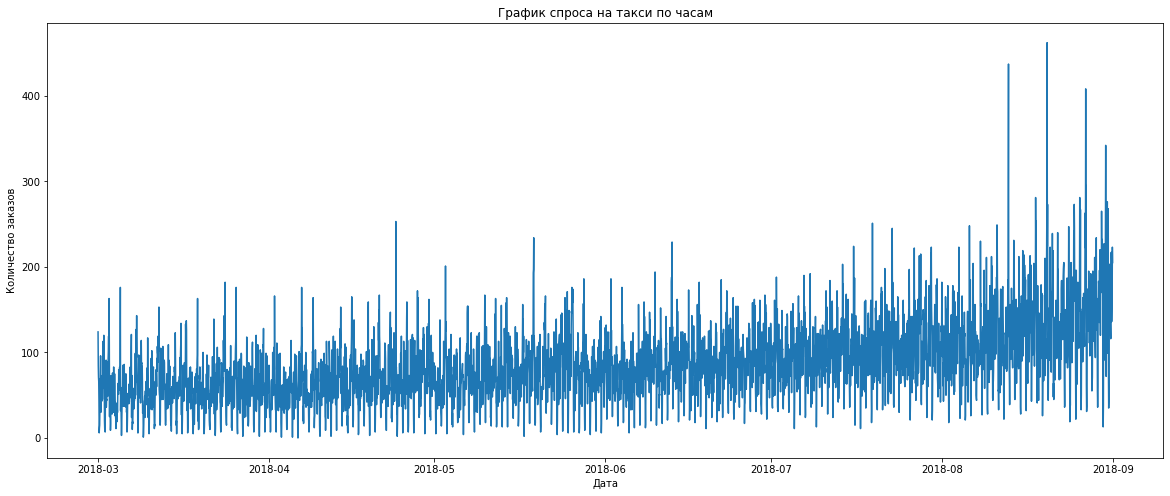

In [7]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(x=df.index, y=df['num_orders'], ax=ax)
plt.title('График спроса на такси по часам')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

Посмотрим на данные поближе

Text(0, 0.5, 'Количество заказов')

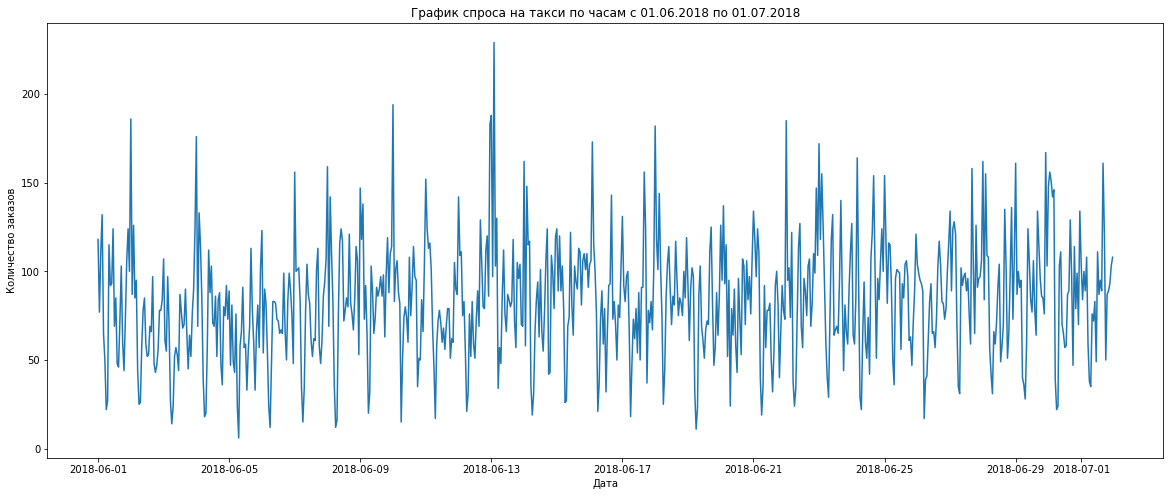

In [8]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.lineplot(x=df['2018-06-01':'2018-07-01'].index,
             y=df['2018-06-01':'2018-07-01']['num_orders'],
             ax=ax)
plt.title('График спроса на такси по часам с 01.06.2018 по 01.07.2018')
plt.xlabel('Дата') 
plt.ylabel('Количество заказов')

### Вывод

На данном этапе мы загрузили исторические данные о заказах такси в аэропортах. Провели ресемплирование по 1 часу и выяснили, что данные предоставлены за 5 месяцев с 01.03.2018 по 31.08.2018

## Анализ

### Проверка ряда на стационароность

Попробуем определить, является ли врменной ряд стационарным. Для этого определим скользящее среднее и стандартное отклонение

In [9]:
df_rolling = df.copy()

In [10]:
df_rolling['mean'] = df_rolling['num_orders'].rolling(15).mean()
df_rolling['std'] = df_rolling['num_orders'].rolling(15).std()

Text(0, 0.5, 'Количество заказов')

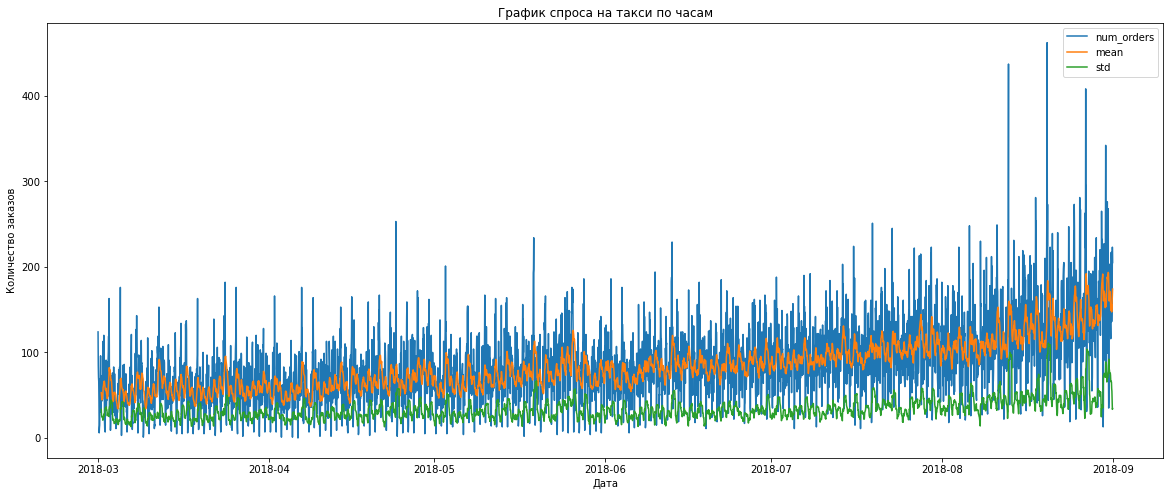

In [11]:
fig, ax = plt.subplots(figsize=(20,8))
for col in ['num_orders', 'mean', 'std']:
    sns.lineplot(x=df_rolling.index, y=df_rolling[col], ax=ax)
plt.legend(['num_orders', 'mean', 'std'])
plt.title('График спроса на такси по часам')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')

#### Вывод

Как мы видим, среднее значение и стандартное отклоение ряда увеличивается, а это говорит о том, что ряд является нестационарным.  
Так же мы видим ежемясячное увеличение тренда. Это говорит о том, что с каждым месяцем такси заказывают все чаще.

### Тренд и сезонность

Для просмотра тренда и сезонности воспользуемся функцией **seasonal_decompose()**. Она раскладывает временной ряд на три составляющие: тренд, сезонность и остаток 

In [12]:
def decomposed_plot(data, trend=True, seasonal=True, resid=True):
    
    
    if trend == True:
        fig, ax = plt.subplots(figsize=(15,5))
        sns.lineplot(x=data.trend.index, y=data.trend, ax=ax)
        plt.title('Тренд')
        plt.xlabel('Дата')
        plt.ylabel('Количество заказов')
        plt.show()

    if seasonal == True:
        fig, ax = plt.subplots(figsize=(15,5))
        sns.lineplot(x=data.seasonal.index, y=data.seasonal, ax=ax)
        plt.title('Сезонность')
        plt.xlabel('Дата')
        plt.ylabel('Количество заказов')
        plt.show()

    if resid == True:
        fig, ax = plt.subplots(figsize=(15,5))
        sns.lineplot(x=data.resid.index, y=data.resid, ax=ax)
        plt.title('Остаток')
        plt.xlabel('Дата')
        plt.ylabel('Количество заказов')
        plt.show()

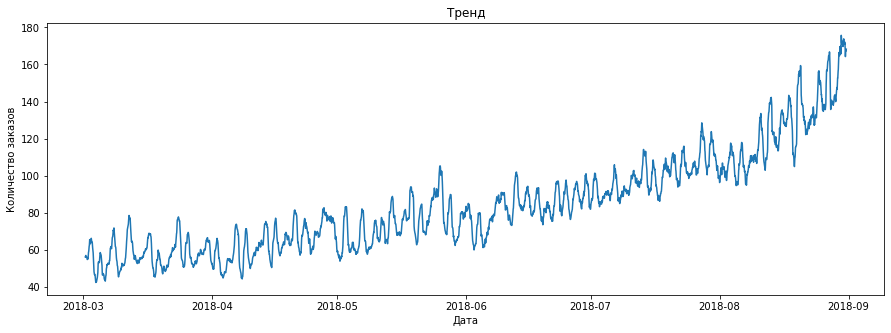

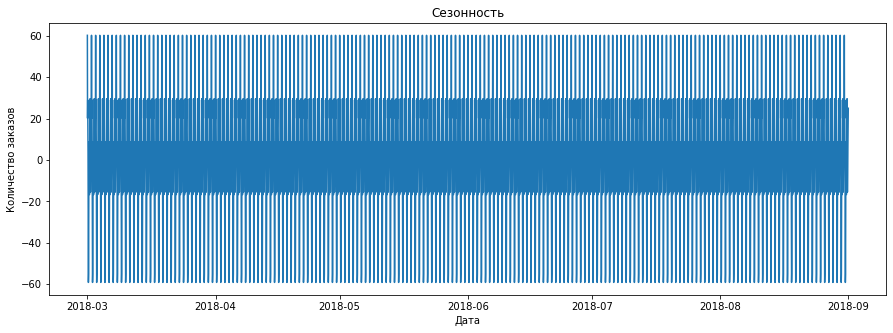

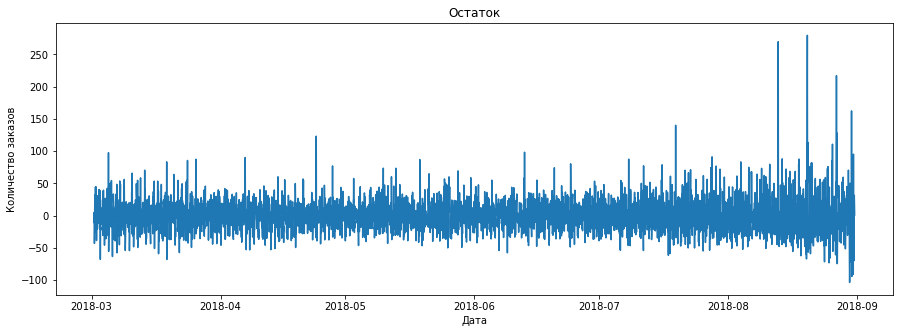

In [13]:
decomposed_plot(seasonal_decompose(df))

Поробуем посмотреть на данные в разрезе 1 месяца

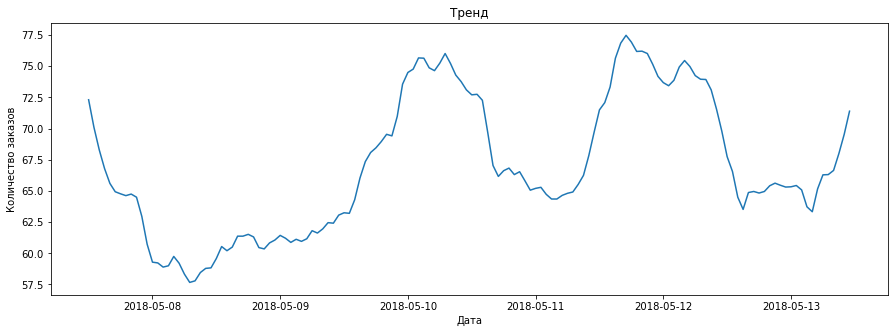

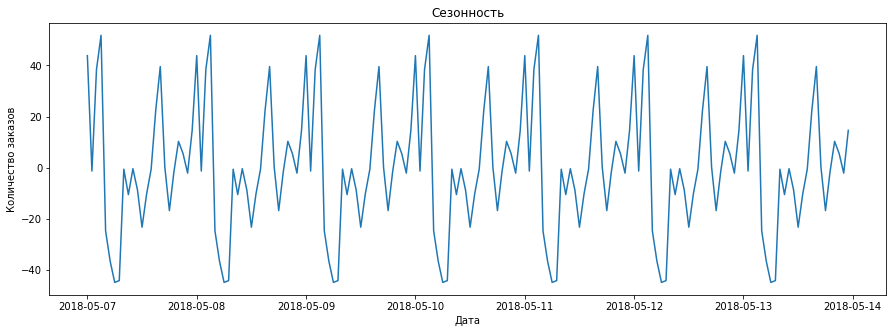

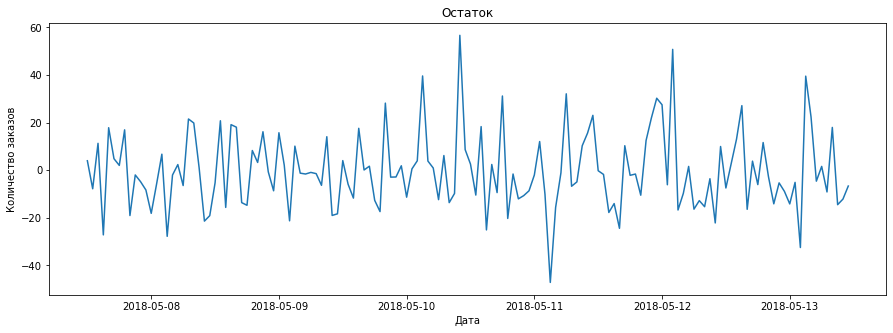

In [14]:
decomposed_plot(seasonal_decompose(df['2018-05-07':'2018-05-13']))

Поробуем посмотреть на данные в разрезе 2 дней

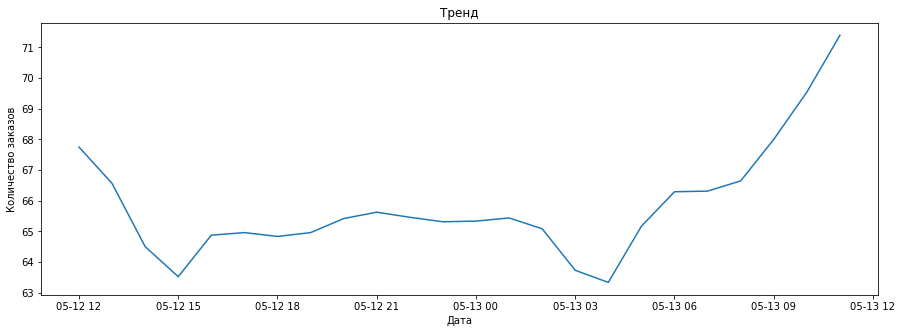

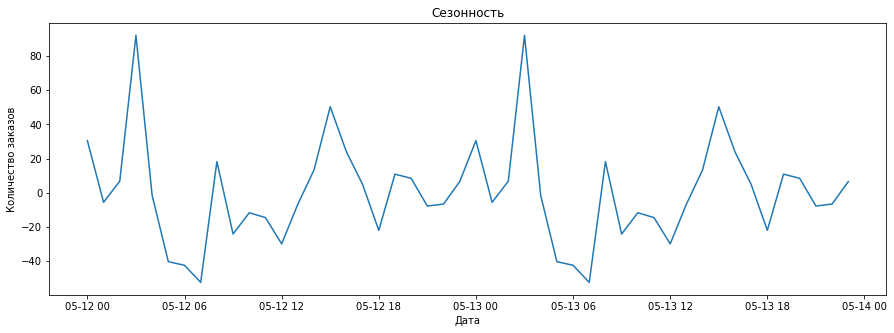

In [15]:
decomposed_plot(seasonal_decompose(df['2018-05-12':'2018-05-13']), resid=False)

#### Вывод

Из графика видно, что после полуночи резко увеличивается количество заказов такси, так как мы рассматриваем заказы такси в аэропорту, возможно подобная тенденция связана с работой общественного транспорта.

## Обучение

Создадим новые признаки:

- месяц
- день
- день недели
- час
- лаги(отставания)
- скользящее среднее

In [16]:
def make_features(df, max_lag, rolling_mean_size):
    
    data = df.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [17]:
df_features = make_features(df, 10, 10)

In [18]:
df_features.head()

,num_orders,month,day,day_of_week,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Теперь напишем функцию для деления данных на обучающую и тестовую выборки

In [19]:
def data_split(data, max_lag, rolling_mean):

    df_to_split = make_features(data, max_lag=max_lag, rolling_mean_size=rolling_mean)

    train, test = train_test_split(df_to_split, test_size=0.1, shuffle=False)
    train = train.dropna()
    features_train = train.drop('num_orders', axis=1)
    target_train = train['num_orders']
    features_test = test.drop('num_orders', axis=1)
    target_test = test['num_orders']

    return features_train, target_train, features_test, target_test

## Тестирование

Обучим разные модели и посмотрим на их результат

In [20]:
results = []

### Линейная регрессия

In [21]:
def lr_fit_predict(df, model_name):
    
    data = df.copy()

    top_rmse = 1000
    rmse_test = 0
    top_lags = 0
    top_mean = 0
    top_time = 0
    top_model = None
    target = None
    predictions = None

    for lag in range(1, 25, 2):

        for rolling_mean in range(5, 51, 5):
            
            start = time.time()
            features_train, target_train, features_test, target_test = data_split(df, lag, rolling_mean)
            model = LinearRegression()

            tscv = TimeSeriesSplit(n_splits=5)
            rmse = np.sqrt(-cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_mean_squared_error')).mean()
            end = time.time() - start
            
            if rmse < top_rmse:
                top_rmse = rmse
                top_lags = lag
                top_mean = rolling_mean
                top_time = end
                top_model = model
                
                model.fit(features_train, target_train)
                predictions = model.predict(features_test)
                rmse_test = np.sqrt(mean_squared_error(target_test, predictions))
                target = target_test
                
    
    return [{
        'Модель': model_name,
        'Параметры': np.nan,
        'Время работы': top_time,
        'Отстающих данных': top_lags,
        'Скользящее среднее': top_mean,
        'RMSE тренировочной выборки': top_rmse,
        'RMSE тестовой выборки': rmse_test,
    }, top_model, pd.DataFrame({'Target':target, 'Prediction':predictions})]

In [22]:
lr_model = lr_fit_predict(df, 'LinearRegression')

In [23]:
results.append(lr_model[0])

In [24]:
pd.DataFrame(results)

,Модель,Параметры,Время работы,Отстающих данных,Скользящее среднее,RMSE тренировочной выборки,RMSE тестовой выборки
0,LinearRegression,NaN,0.039384,23,25,28.232413,46.004862


<AxesSubplot:xlabel='datetime'>

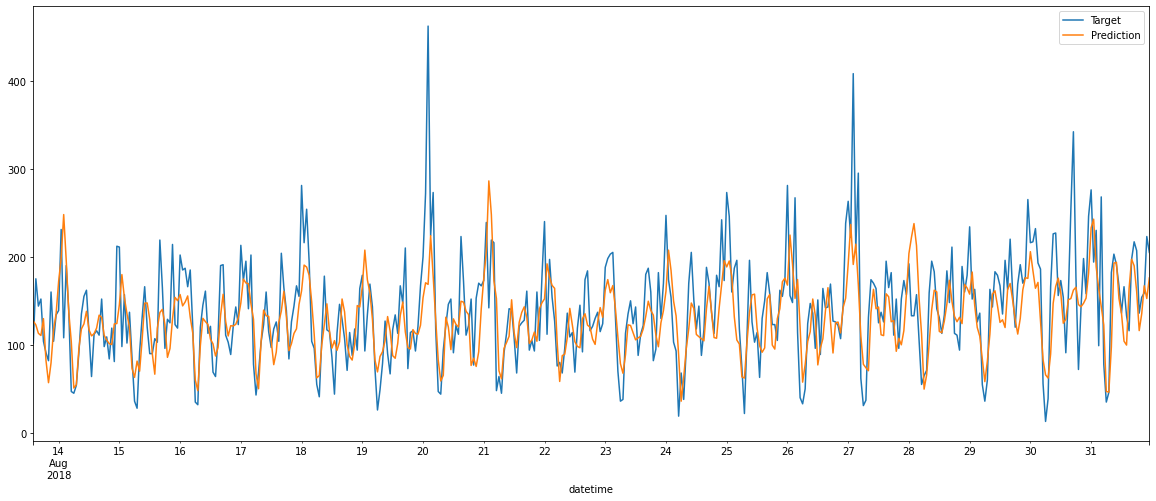

In [25]:
lr_model[2].plot(figsize=(20,8))

### Случайный лес

In [26]:
def rf_fit_predict(df, model_name):

    data = df.copy()

    top_rmse = 1000
    rmse_test = 0
    top_lags = 0
    top_mean = 0
    top_depth = 0
    top_est = 0
    top_time = 0
    top_model = None
    target = None
    predictions = None

    for lag in [1, 5, 15, 24]:
        
        for rolling_mean in [5, 10, 24, 48]:

            for depth in [5, 25, 50]:

                for est in [50, 60, 70]:

                    start = time.time()
                    features_train, target_train, features_test, target_test = data_split(
                        df, lag, rolling_mean)
                    model = RandomForestRegressor(max_depth=depth,
                                                  n_estimators=est,
                                                  random_state=123)

                    tscv = TimeSeriesSplit(n_splits=5)
                    rmse = np.sqrt(-cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_mean_squared_error')).mean()
                    end = time.time() - start

                    if rmse < top_rmse:
                        top_rmse = rmse
                        top_lags = lag
                        top_mean = rolling_mean
                        top_depth = depth
                        top_est = est
                        top_time = end
                        top_model = model
                    
                    model.fit(features_train, target_train)
                    predictions = model.predict(features_test)
                    rmse_test = np.sqrt(mean_squared_error(target_test, predictions))
                    target = target_test

    return [{
        'Модель': model_name,
        'Параметры': {'Глубина дерева': top_depth, 'Количество деревьев': top_est},
        'Время работы': top_time,
        'Отстающих данных': top_lags,
        'Скользящее среднее': top_mean,
        'RMSE тренировочной выборки': top_rmse,
        'RMSE тестовой выборки': rmse_test,
    }, top_model, pd.DataFrame({'Target':target, 'Prediction':predictions})]

In [27]:
rf_model = rf_fit_predict(df, 'RandomForestRegressor')

In [28]:
results.append(rf_model[0])

In [29]:
pd.DataFrame(results)

,Модель,Параметры,Время работы,Отстающих данных,Скользящее среднее,RMSE тренировочной выборки,RMSE тестовой выборки
0,LinearRegression,NaN,0.039384,23,25,28.232413,46.004862
1,RandomForestRegressor,"{'Глубина дерева': 50, 'Количество деревьев': 70}",5.046175,15,48,24.933467,44.172162


<AxesSubplot:xlabel='datetime'>

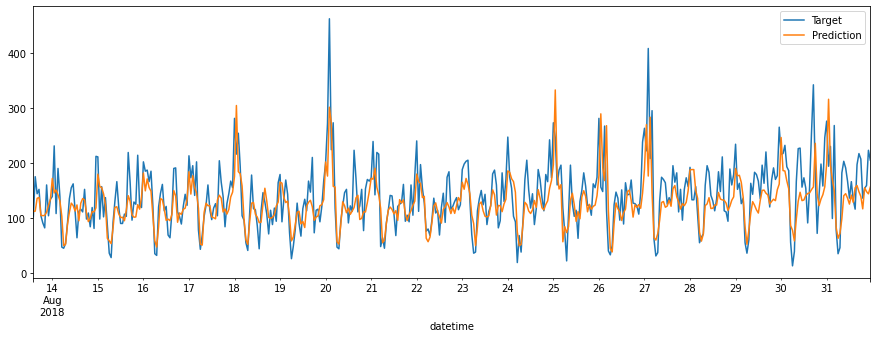

In [30]:
rf_model[2].plot(figsize=(15,5))

### LGBMRegressor

In [31]:
def lgbm_fit_predict(df, model_name):

    top_rmse = 100
    top_lags = 0
    top_mean = 0
    top_depth = 0
    top_est = 0
    top_time = 0
    rmse_test = 0
    top_model = None
    target = None
    predictions = None

    for lag in [1, 5, 15, 24]:
    
        for rolling_mean in [5, 10, 24, 48]:
    
            for depth in [10, 25, 50]:
    
                for est in [40, 75]:
            
                    start = time.time()
                    features_train, target_train, features_test, target_test = data_split(
                        df, lag, rolling_mean)
                    model = LGBMRegressor(max_depth=depth,
                                          n_estimators=est,
                                          random_state=123)
    
                    tscv = TimeSeriesSplit(n_splits=5)
                    rmse = np.sqrt(-cross_val_score(model, features_train, target_train, cv=tscv, scoring='neg_mean_squared_error')).mean()
                    end = time.time() - start
    
                    if rmse < top_rmse:
                        
                        top_rmse = rmse
                        top_lags = lag
                        top_mean = rolling_mean
                        top_depth = depth
                        top_est = est
                        top_time = end
                        top_model = model
                        
                        model.fit(features_train, target_train)
                        predictions = model.predict(features_test)
                        rmse_test = np.sqrt(mean_squared_error(target_test, predictions))
                        target = target_test
                        
    
    return [{
        'Модель': model_name,
        'Параметры': {'Глубина дерева': top_depth, 'Количество деревьев': top_est},
        'Время работы': top_time,
        'Отстающих данных': top_lags,
        'Скользящее среднее': top_mean,
        'RMSE тренировочной выборки': top_rmse,
        'RMSE тестовой выборки': rmse_test,
    }, top_model, pd.DataFrame({'Target':target, 'Prediction':predictions})]

In [32]:
lgbm_model = lgbm_fit_predict(df, 'LGBMRegressor')

In [33]:
results.append(lgbm_model[0])

In [34]:
pd.DataFrame(results)

,Модель,Параметры,Время работы,Отстающих данных,Скользящее среднее,RMSE тренировочной выборки,RMSE тестовой выборки
0,LinearRegression,NaN,0.039384,23,25,28.232413,46.004862
1,RandomForestRegressor,"{'Глубина дерева': 50, 'Количество деревьев': 70}",5.046175,15,48,24.933467,44.172162
2,LGBMRegressor,"{'Глубина дерева': 25, 'Количество деревьев': 75}",0.234294,15,5,24.879201,42.844911


<AxesSubplot:xlabel='datetime'>

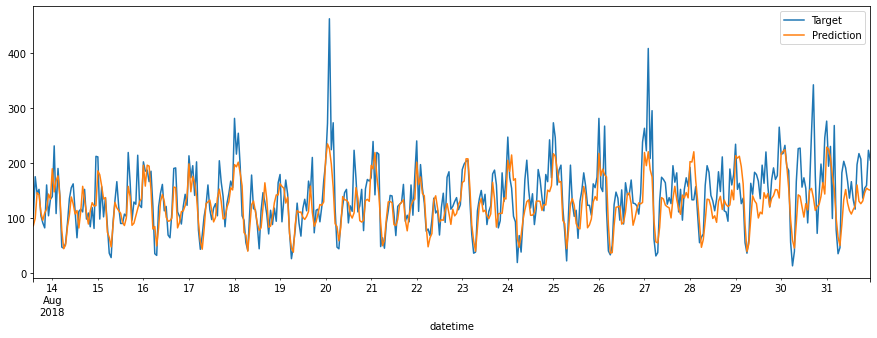

In [35]:
lgbm_model[2].plot(figsize=(15,5))

### Вывод

Мы обучили 3 модели и получили следущие результаты:

1) Линейная регрессия, **RMSE** равный 45.609877

2) Случайный лес, **RMSE** равный 42.993718 с параметрами:
- 'Глубина дерева': 25
- 'Количество деревьев': 60

3) LGBMRegressor, **RMSE** равный 40.539582 с параметрами:
- 'Глубина дерева': 25
- 'Количество деревьев': 75

Как мы видим, лучший результат показала модель **LGBMRegressor**